<a href="https://colab.research.google.com/github/BautiSobenko/IA-2022/blob/main/EJ1_Diodo_Sugeno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### **Subtractive Algorithm**

In [25]:
"""Subtractive Clustering Algorithm
"""
__author__ = 'Daniel Albornoz'


import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix

def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb==0:
        Rb = Ra*1.15
        
    scaler = MinMaxScaler()
    scaler.fit(data) 
    ndata = scaler.transform(data)
    
    # 14/05/2020 cambio list comprehensions por distance matrix
    #P = np.array([np.sum([np.exp(-(np.linalg.norm(u-v)**2)/(Ra/2)**2) for v in ndata]) for u in ndata])
    #print(P)
    P = distance_matrix(ndata,ndata)
    alpha=(Ra/2)**2
    P = np.sum(np.exp(-P**2/alpha),axis=0)
   
    centers = []
    i=np.argmax(P)
    C = ndata[i]
    p=P[i]
    centers = [C]
    
    continuar=True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P=P-p*np.array([np.exp(-np.linalg.norm(v-C)**2/(Rb/2)**2) for v in ndata])            
        restarP = True  
        i=np.argmax(P)
        C = ndata[i]
        p=P[i]
        if p>AcceptRatio*pAnt:
            centers = np.vstack((centers,C))
        elif p<RejectRatio*pAnt:
            continuar=False
        else: 
            dr = np.min([np.linalg.norm(v-C) for v in centers])
            if dr/Ra+p/pAnt>=1:
                centers = np.vstack((centers,C))
            else:
                P[i]=0
                restarP = False
        if not any(v>0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p-c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)

    return labels, centers

### **Sugeno algorithm** 

In [76]:
# -*- coding: utf-8 -*-
"""
Created on Wed May  6 17:56:16 2020

@author: Daniel Albornoz

Implementación similar a genfis2 de Matlab.
Sugeno type FIS. Generado a partir de clustering substractivo.

"""
__author__ = 'Daniel Albornoz'

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import time

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean)**2.) / (2 * sigma**2.))
    
class fisRule:
    def __init__(self, centroid, sigma):
        self.centroid = centroid
        self.sigma = sigma
    
class fisInput:
    def __init__(self, min,max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    
    def view(self):
        x = np.linspace(self.minValue,self.maxValue,20)
        plt.figure(figsize=(12,12))
        for m in self.centroids:
            s = (self.minValue-self.maxValue)/8**0.5
            y = gaussmf(x,m,s)
            plt.title("GAUSSIANAS - REGLAS: {}".format(self.centroids.size))
            plt.xlabel("Tension (V)") # Agregamos labels a los ejes
            plt.ylabel("Grado de pertenencia μ")
            plt.plot(x,y)
        
class fis:
    def __init__(self):
        self.rules=[]
        self.memberfunc = []
        self.inputs = []
        
   
    
    def genfis(self, data, radii):

        start_time = time.time()
        labels, cluster_center = subclust2(data, radii)
        
        print("--- %s seconds ---" % (time.time() - start_time))
        n_clusters = len(cluster_center)
        
        cluster_center = cluster_center[:,:-1]
        P = data[:,:-1]
        #T = data[:,-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)       
     
        self.inputs = [fisInput(maxValue[i], minValue[i],cluster_center[:,i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:,:-1]
        T = data[:,-1]
        #___________________________________________
        # MINIMOS CUADRADOS (lineal)
        sigma = np.array([(i.maxValue-i.minValue)/np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P,cluster,sigma),axis=1) for cluster in self.rules]
        
        nivel_acti = np.array(f).T
        #print("nivel acti")
        #print(nivel_acti)
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
        #print("sumMu")
        #print(sumMu)
        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]
        
        orden = np.tile(np.arange(0,n_vars), len(self.rules))
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        
        
        A = acti*inp/sumMu
        
        # A = np.zeros((N, 2*n_clusters))
        # for jdx in range(n_clusters):
        #     for kdx in range(nVar):
        #         A[:, jdx+kdx] = nivel_acti[:,jdx]*P[:,kdx]/sumMu
        #         A[:, jdx+kdx+1] = nivel_acti[:,jdx]/sumMu
        
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A,b,rcond=None)
        self.solutions = solutions #.reshape(n_clusters,n_vars)
        print(solutions)
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue-input.minValue) for input in self.inputs])/np.sqrt(8)
        f = [np.prod(gaussmf(data,cluster,sigma),axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti,axis=1))
         
        P = np.c_[data, np.ones(len(data))]
        
        n_vars = P.shape[1]
        n_clusters = len(self.rules)
        
        orden = np.tile(np.arange(0,n_vars), n_clusters)
        acti = np.tile(nivel_acti,[1,n_vars])
        inp = P[:, orden]
        coef = self.solutions
        
        return np.sum(acti*inp*coef/sumMu,axis=1)
        
    
    def viewInputs(self):
        for input in self.inputs:
            input.view()

### **Importo Raw df**

In [27]:
!wget https://raw.githubusercontent.com/BautiSobenko/IA-2022/main/datosDiodo.txt

--2022-09-18 16:03:02--  https://raw.githubusercontent.com/BautiSobenko/IA-2022/main/datosDiodo.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542 [text/plain]
Saving to: ‘datosDiodo.txt.1’

datosDiodo.txt.1    100%[===================>]     542  --.-KB/s    in 0s      

2022-09-18 16:03:02 (26.1 MB/s) - ‘datosDiodo.txt.1’ saved [542/542]



In [28]:
# V = Tension en bornes
# I = Corriente que atraviesa el diodo
df = pd.read_csv("datosDiodo.txt", sep="\t", header=None, names=["V","I"] )

In [29]:
df.head()

,V,I
0,0.46,0.00005
1,0.48,0.00010
2,0.51,0.00020
3,0.53,0.00030
4,0.54,0.00040


In [30]:
df.describe()

,V,I
count,38.000000,38.000000
mean,0.599105,0.002181
std,0.049144,0.001726
min,0.460000,0.000050
25%,0.580000,0.000925
50%,0.604500,0.001650
75%,0.636750,0.003258
max,0.665000,0.006061


### **Ploteo del dataframe**

Text(0, 0.5, 'Corriente atravesando el diodo (I)')

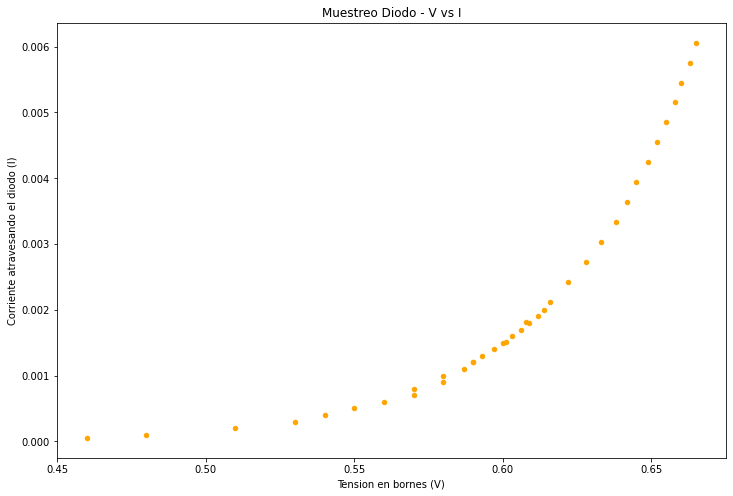

In [31]:
plt.figure(figsize = (12,8))
plt.scatter(df["V"], df["I"], c = "orange", s = 20)
plt.title("Muestreo Diodo - V vs I")
plt.xlabel("Tension en bornes (V)")
plt.ylabel("Corriente atravesando el diodo (I)")

--- 0.005342960357666016 seconds ---
[ 0.6326808  -0.66118634  0.05150086 -0.27424033  0.84773665 -0.02024658]


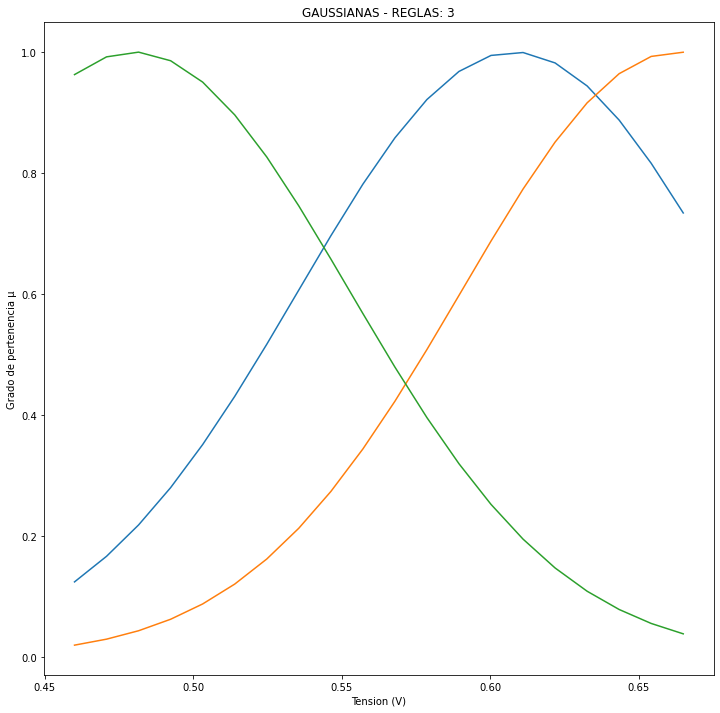

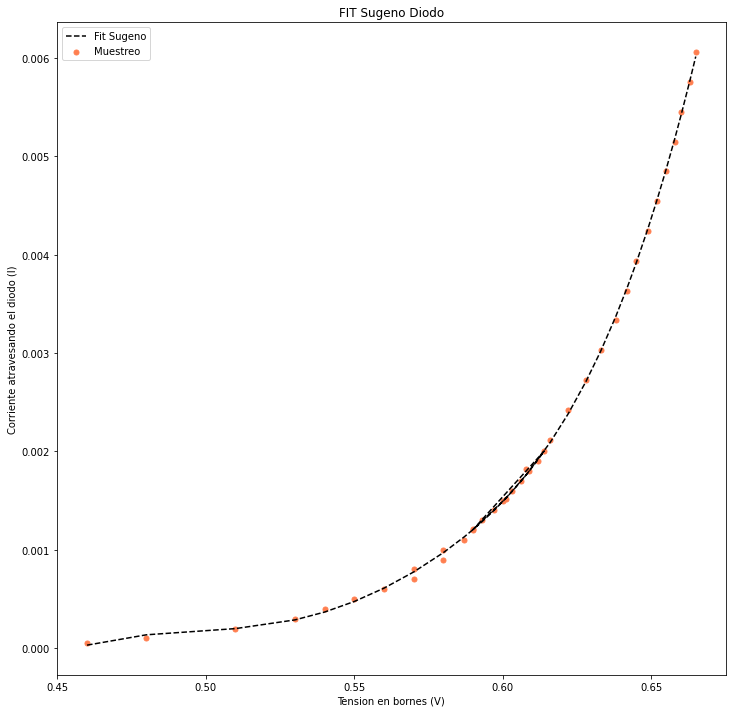

In [77]:
radii = 1.3

fis2 = fis()
fis2.genfis(np.array(df), radii)
fis2.viewInputs()

r = fis2.evalfis(np.vstack(df["V"]))

plt.figure(figsize=(12,12))
plt.title("FIT Sugeno Diodo")
plt.xlabel("Tension en bornes (V)")
plt.ylabel("Corriente atravesando el diodo (I)")
plt.scatter(df["V"],df["I"],c="coral",s=25)
plt.plot(df["V"],r,c="black",linestyle='--');
plt.legend(["Fit Sugeno","Muestreo" ])
